<a href="https://colab.research.google.com/github/pingao2019/DS-Unit-2-Linear-Models/blob/master/PingAo_of_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ x] Begin with baselines for classification.
- [ x] Use scikit-learn for logistic regression.
- [ x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ x] Get your model's test accuracy. (One time, at the end.)
- [ x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [x ] Make exploratory visualizations.
- [ x] Do one-hot encoding.
- [ x] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ x] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler



In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
df.isnull().sum()

In [0]:
df.columns.to_list()

In [0]:
print(df.shape)

(423, 66)


In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
print(df.shape)
df.head()

(421, 67)


,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
df.columns.to_list()

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
print(df.shape)
df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
import datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


df.shape

(421, 60)


In [0]:
# Do train/test split
# Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
cutoff = pd.to_datetime('2017-01-01')
train = df[df.Date< cutoff]


In [0]:
#train = train.drop(['Great'],inplace= True, axis= 1)
train.drop(columns=['Great'])
train.head()

In [0]:
cutoff = pd.to_datetime('2018-01-01')
test  = df[df.Date >= cutoff]



In [0]:
#Begin with baselines for classification.
train, val = train_test_split(train, random_state=42)
train.shape, val.shape, test.shape


((167, 60), (56, 60), (38, 60))

In [0]:
#Determine majority class
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.592814
True     0.407186
Name: Great, dtype: float64

### 59.3% is evaluated to great('overall'*italicized text* >= 4). 40.7% is not great.

In [0]:
#What if we guessed the majority class for every prediction?
#What is the baseline accuracy if we guessed the majority class for every prediction?
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)


In [0]:
# Training accuracy of majority class baseline = 
# frequency of majority class (aka base rate)
accuracy_score(y_train, y_pred)

0.592814371257485

In [0]:
# Validation accuracy of majority class baseline = 
# usually similar to Train accuracy
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.5357142857142857

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
train.columns.to_list()

['Burrito',
 'Date',
 'Yelp',
 'Google',
 'Chips',
 'Cost',
 'Hunger',
 'Mass (g)',
 'Density (g/mL)',
 'Length',
 'Circum',
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap',
 'Unreliable',
 'NonSD',
 'Beef',
 'Pico',
 'Guac',
 'Cheese',
 'Fries',
 'Sour cream',
 'Pork',
 'Chicken',
 'Shrimp',
 'Fish',
 'Rice',
 'Beans',
 'Lettuce',
 'Tomato',
 'Bell peper',
 'Carrots',
 'Cabbage',
 'Sauce',
 'Salsa.1',
 'Cilantro',
 'Onion',
 'Taquito',
 'Pineapple',
 'Ham',
 'Chile relleno',
 'Nopales',
 'Lobster',
 'Queso',
 'Egg',
 'Mushroom',
 'Bacon',
 'Sushi',
 'Avocado',
 'Corn',
 'Zucchini',
 'Great',
 'year']

### From the website"https://srcole.github.io/100burritos/", customers care about top ten items as  Volume,Tortilla quality, Temperature, Meat quality, Non-meat filling quality, Meat : filling , Uniformity, Salsa quality ,Flavor synergy, and Wrap integrity.


In [0]:
features = [
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap',
 'Cheese',
 'Sour cream' 
 ]
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((167, 12), (167,), (56, 12), (56,))

In [0]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_train_encoded.head()

,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Cheese_nan,Cheese_x,Cheese_X,Sour cream_nan,Sour cream_X,Sour cream_x
294,0.40,3.5,4.0,3.0,4.00,3.5,4.0,3.0,4.0,4.5,1,0,0,1,0,0
34,NaN,3.0,5.0,4.0,2.75,4.0,1.6,3.5,3.4,5.0,0,1,0,1,0,0
246,0.77,4.0,4.0,4.0,4.00,4.5,4.0,4.0,4.0,2.5,0,1,0,1,0,0
133,NaN,5.0,5.0,5.0,5.00,5.0,5.0,5.0,5.0,5.0,1,0,0,1,0,0
225,0.75,3.0,4.5,4.0,4.00,3.5,3.0,4.0,4.0,5.0,0,0,1,0,1,0


In [0]:
X_val_encoded.head()

,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Cheese_nan,Cheese_x,Cheese_X,Sour cream_nan,Sour cream_X,Sour cream_x
91,0.70,3.0,4.0,2.7,4.7,3.0,2.4,2.0,3.7,4.5,0,1,0,1,0,0
12,NaN,3.0,3.5,3.5,4.0,2.0,3.5,1.0,4.0,4.0,0,1,0,1,0,0
11,NaN,3.0,4.0,4.0,3.0,4.0,4.0,1.0,2.0,1.0,1,0,0,1,0,0
219,0.63,5.0,3.0,5.0,5.0,3.0,2.0,2.0,3.0,5.0,0,1,0,0,0,1
107,NaN,3.0,NaN,4.0,4.0,5.0,4.0,4.0,5.0,4.0,1,0,0,1,0,0


In [0]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [0]:
X_train_imputed[:5]

array([[0.4       , 3.5       , 4.        , 3.        , 4.        ,
        3.5       , 4.        , 3.        , 4.        , 4.5       ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.76252525, 3.        , 5.        , 4.        , 2.75      ,
        4.        , 1.6       , 3.5       , 3.4       , 5.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.77      , 4.        , 4.        , 4.        , 4.        ,
        4.5       , 4.        , 4.        , 4.        , 2.5       ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.76252525, 5.        , 5.        , 5.        , 5.        ,
        5.        , 5.        , 5.        , 5.        , 5.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.75      , 3.        , 4.5       , 4.        , 4.        ,
        3.5       , 3.        , 

In [0]:
X_val_imputed[:5]

array([[0.7       , 3.        , 4.        , 2.7       , 4.7       ,
        3.        , 2.4       , 2.        , 3.7       , 4.5       ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.76252525, 3.        , 3.5       , 3.5       , 4.        ,
        2.        , 3.5       , 1.        , 4.        , 4.        ,
        0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.76252525, 3.        , 4.        , 4.        , 3.        ,
        4.        , 4.        , 1.        , 2.        , 1.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.63      , 5.        , 3.        , 5.        , 5.        ,
        3.        , 2.        , 2.        , 3.        , 5.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.76252525, 3.        , 3.8056962 , 4.        , 4.        ,
        5.        , 4.        , 

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [0]:
X_train_scaled[:5]

array([[-3.14904908e+00,  4.98631826e-02,  2.18381473e-01,
        -6.56548546e-01,  5.80586099e-01,  4.01078747e-02,
         5.87459404e-01, -4.33374966e-01,  4.51994285e-01,
         4.48629728e-01,  9.82194422e-01, -7.78311782e-01,
        -3.58299286e-01,  6.35107349e-01, -3.14140431e-01,
        -4.96254629e-01],
       [ 9.64387107e-16, -5.62427368e-01,  1.34229915e+00,
         5.46058979e-01, -9.62932357e-01,  5.23551007e-01,
        -1.62810178e+00,  7.47644638e-02, -2.16876182e-01,
         8.91356434e-01, -1.01812836e+00,  1.28483215e+00,
        -3.58299286e-01,  6.35107349e-01, -3.14140431e-01,
        -4.96254629e-01],
       [ 6.49288470e-02,  6.62153733e-01,  2.18381473e-01,
         5.46058979e-01,  5.80586099e-01,  1.00699414e+00,
         5.87459404e-01,  5.82903893e-01,  4.51994285e-01,
        -1.32227709e+00, -1.01812836e+00,  1.28483215e+00,
        -3.58299286e-01,  6.35107349e-01, -3.14140431e-01,
        -4.96254629e-01],
       [ 9.64387107e-16,  1.88673483e

In [0]:
X_val_scaled[:5]

array([[-5.43121031e-01, -5.62427368e-01,  2.18381473e-01,
        -1.01733080e+00,  1.44495643e+00, -4.43335257e-01,
        -8.89581383e-01, -1.44965382e+00,  1.17559052e-01,
         4.48629728e-01, -1.01812836e+00,  1.28483215e+00,
        -3.58299286e-01,  6.35107349e-01, -3.14140431e-01,
        -4.96254629e-01],
       [ 9.64387107e-16, -5.62427368e-01, -3.43577367e-01,
        -5.52447832e-02,  5.80586099e-01, -1.41022152e+00,
         1.25884158e-01, -2.46593268e+00,  4.51994285e-01,
         5.90302274e-03, -1.01812836e+00,  1.28483215e+00,
        -3.58299286e-01,  6.35107349e-01, -3.14140431e-01,
        -4.96254629e-01],
       [ 9.64387107e-16, -5.62427368e-01,  2.18381473e-01,
         5.46058979e-01, -6.54228666e-01,  5.23551007e-01,
         5.87459404e-01, -2.46593268e+00, -1.77757394e+00,
        -2.65045721e+00,  9.82194422e-01, -7.78311782e-01,
        -3.58299286e-01,  6.35107349e-01, -3.14140431e-01,
        -4.96254629e-01],
       [-1.15117091e+00,  1.88673483e

In [0]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [0]:
y_pred = model.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.875

In [0]:
# Another way
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.875


Plot coefficients:

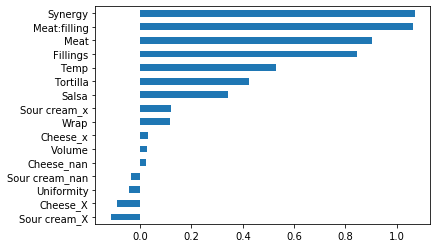

In [0]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

## Conclusion, from above results, for customers whether gave 'Great' evaluation, which was positive related to 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',  'Salsa', 'Synergy', wrap', we prove the website's opinion. 